# Tutorial 4 -- Pointer to solution

Author: "Sarah Filippi". 

In [3]:
# load packages and set seed
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

Consider the Million Song Data Set described here: https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD). 
We start by loading the provided dataset.

In [4]:
df = pd.read_csv('dataMS.csv')
df.head()



,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91
0,1933,35.52117,-173.08203,46.48577,-5.06276,-63.82789,24.02641,-41.02192,4.62923,-16.18052,...,59.13603,-40.20129,-49.39461,24.85517,-5.71430,-211.76905,29.05489,-15.60849,-53.62467,5.16082
1,1930,20.82134,-105.06227,-43.18894,-48.94628,9.38217,18.50846,-47.86844,16.39423,-40.76835,...,70.58999,-199.31135,-43.84401,405.88548,-12.19678,-0.66015,676.59875,-26.87764,-62.47564,45.08777
2,1935,28.23865,-210.09303,17.52676,2.19025,32.08925,0.44376,11.65822,24.40600,-49.33061,...,32.66179,135.07781,-99.65834,181.84890,-4.89541,-252.83162,70.21382,-2.21501,23.60526,4.99606
3,1941,31.96273,-101.69543,41.96745,-4.76271,3.56367,36.30043,7.73083,17.25277,-2.42944,...,40.24099,-247.91642,454.80976,611.16708,-48.77300,56.66697,150.06551,14.10275,81.94839,30.90205
4,1930,35.55615,-56.58205,62.04075,-7.53863,-84.55047,36.35813,-57.28277,-1.46895,21.04464,...,24.98972,-119.42711,-184.94459,234.78532,7.44422,-168.61733,244.36084,-25.50052,81.87296,31.26154


We then extract the features and the year of the song into two numpy arrays.

In [5]:
X = df.drop(['V1'], axis=1)
X = X.to_numpy()
print(X.shape)

y = df['V1'].to_numpy()
print(y.shape)

(12523, 90)
(12523,)


# Question 1


## a) Fitting a random forest regression model


Here we use the `RandomForestRegressor` function from the `sklearn.ensemble` module. Please read carefully the help file of this package to see what are the parameters that one can input (as well as their default values) and the attributes of the function: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In the code below we use the default parameters and specify that we want to use the out-of-bag score as a generalization score.


In [11]:
from sklearn import ensemble

# Define the model
model = ensemble.RandomForestRegressor(oob_score=True)

# Fit the model on the entire dataset  
model.fit(X, y)

# Print the number of trees used
print(f'Number of trees: {model.n_estimators}')

Number of trees: 100


## b) Making predictions

Once we have fitted the model we can use it to make predictions using the function `predict`. Below we compare the prediction on the training data to the OOB error prediction for the same training data (computed during model fit).

(12523,)
(12523,)


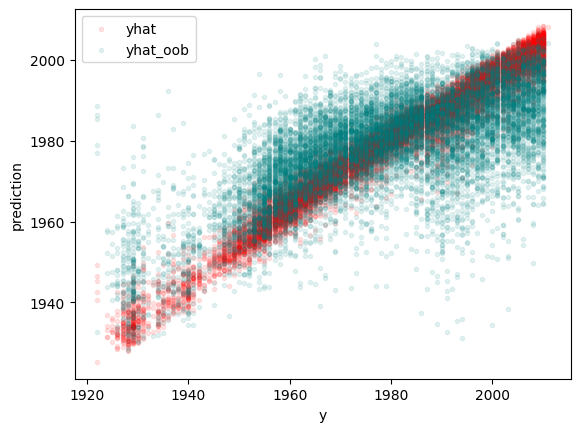

In [12]:
#since we did OOB=TRUE
#OOB is the entire training set but when used as OOB
yhat_oob = model.oob_prediction_
yhat = model.predict(X)

print(yhat.shape)
print(yhat_oob.shape)

plt.scatter(y, yhat, color='red', marker='.', label='yhat', alpha=0.1)
plt.scatter(y, yhat_oob, color='teal', marker='.', label='yhat_oob', alpha=0.1)
# plt.axline((0, 0), slope=1, color="black")
plt.xlabel('y')
plt.ylabel('prediction')
plt.legend()

#better on red than blue since it is training data
#blue is similar to test set

## c) Mean-squared error of OOB predictions

The predictions `yhat` are made on the same examples as `yhat_oob`, but the predictions are different.
* Why is this?
* Which would you expect to have the lower mean squared error (MSE)? Calculate the MSE for each set of predictions and check.
* What is the reason for this difference?
* What does this difference imply for model selection?

In [12]:
from sklearn.metrics import mean_squared_error

mse_yhat = mean_squared_error(yhat, y)
mse_yhat_oob = mean_squared_error(yhat_oob, y)

print(f'Yhat MSE: {round(mse_yhat, 3)}')
print(f'Yhat-OOB MSE: {round(mse_yhat_oob, 3)}')

NameError: name 'yhat' is not defined

* `yhat` are the aggregated predictions from the whole forest on the training data, while `yhat_oob` are the aggregated predictions from the trees that did not see the examples during training.
* The OOB predictions will have a larger MSE.
* The OOB predictions are only made by trees that have not seen those examples before.
* The OOB predictions can be used for model selection as they are closer to true estimates of the generalisation performance. The predictions in `yhat` are optimistically biased and so should not be used for model selection.

## d) Random forest hyperparameters

The main hyperparameters of randomForest are :
* the number of features considered at each split point (`max_features`)
* the number of trees in the forest (`n_estimators`)
* the maximum number of leaf nodes (`max_leaf_nodes`)
* the maximum depth of the tree (`max_depth`)
* the minimum number of samples required to be at a leaf node (`min_samples_leaf`)
 ...

There is not a general rule for which values of `max_features` will underfit or overfit a particular dataset - you must try a range of values during training. However, as the value of `max_features` approaches the number of features the individual trees in the forest will become more correlated as they consider more similar sets of features. This can lead to worse performance as bagging assumes that the base learners are approximately independent. The computational cost of the RF algorithm is linear in `max_features`.

For fixed values of the other hyperparameters, increasing the number of trees cannot lead to additional overfitting. This is because adding trees reduces the variance of the full model. Increasing the number of trees also gives more stable results, although is more computationally expensive (fitting the tree is linear in `n_estimators`). In general, you want to select the lowest value of `n_estimators` that gives stable results

The hyper-parameters `max_leaf_nodes`, `min_samples_split`, `max_depth` and other ones related to the depth of the tree are strongly related to each other. A deep tree or a tree containing only one sample per leaves is likely to overfit the training data. The other extreme leads to decision stumps (trees with only one level), which are likely to underfit the training data. A suitable intermediate value should be selected during the training phase.

## e) Selecting hyperparameters using OOB error

Above we used default hyperparameters, but in general hyperparameters must be selected as part of model selection. One common approach is to use the OOB error estimates to identify hyperparameters. 

Below we consider three hyperparameters: `max_features` and `max_leaf_nodes`. 

Note that fitting a random forest model on such a large and complex dataset can be computationnally expensive. It is wise to start with a small grid of hyperparameters values, especially when debugging the code.

In [14]:
# model selecion using cross-validation

from sklearn.model_selection import train_test_split

# split the data into training and testing sets
TEST_SIZE = 0.6
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

# range of values considered for the number of features to consider at each split (from 5 to 90)
mtrys = list(range(5, 91, 20))
# range of values considered for the maximum number of leaf nodes
maxnodes = list(range(20, 100, 20))

# initialize the matrix of out-of-bag scores
oob_scores = np.zeros((len(mtrys), len(maxnodes)))

print('Training models...')
for i, mtry in enumerate(mtrys):
    print(f'Progress: {round(i / len(mtrys) * 100, 2)}%', end='\r')
    for j, maxnode in enumerate(maxnodes):
        model = ensemble.RandomForestRegressor(oob_score=True, max_features=mtry, max_leaf_nodes=maxnode, random_state=SEED)
        model.fit(train_X, train_y)
        oob_scores[i, j] = mean_squared_error(model.oob_prediction_, train_y)
print('Finished!')


Training models...
Finished! 80.0%


We can then identify the hyperparameter combinations that minimise the OOB error on the training set. It is good practice to also explore the difference in terms of OOB error for the different hyperparameter values.

In [15]:
idx_mtry, idx_maxnode = np.unravel_index(np.argmin(oob_scores), oob_scores.shape)
mtry = mtrys[idx_mtry]
maxnode = maxnodes[idx_maxnode]
print(f'Best mtry: {mtry}')
print(f'Best maxnode: {maxnode}')

Best mtry: 45
Best maxnode: 80


We now compare the MSE on the test set for both a random forest with the default hyperparameters and the ones that minimise the OOB error.

In [16]:
def train_pred_mse(model, train_X, train_y, test_X, test_y):
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)
    return mean_squared_error(pred_y, test_y)


#now on the completely separate test set
default_model = ensemble.RandomForestRegressor(random_state=SEED)
default_mse = train_pred_mse(default_model, train_X, train_y, test_X, test_y)

tuned_model = ensemble.RandomForestRegressor(max_features=mtry, max_leaf_nodes=maxnode, random_state=SEED)
tuned_mse = train_pred_mse(tuned_model, train_X, train_y, test_X, test_y)

print(f'Tuned model MSE: {round(tuned_mse, 3)}')
print(f'Default model MSE: {round(default_mse, 3)}')

Tuned model MSE: 208.013
Default model MSE: 200.799


## f) Variable importance

We now compute the variable importance with two different approaches: (1) based on the mean decrease in impurity and (2) based on feature permutation. Please read the documentation for more information on the implementation of these feature importance techniques in sklearn: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-mean-decrease-in-impurity

Feature importances based on the mean decrease in impurity are provided by the fitted attribute `feature_importances_` and are computed along the training of the model in this package.

Permutation importance needs to be computed afterwards.

In [17]:
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr

# Feature importance based on mean decrease in impurity
impurity_importances = tuned_model.feature_importances_

# Feature importance based on permutation
mse_importances = permutation_importance(
    tuned_model, test_X, test_y, n_repeats=10, random_state=42, n_jobs=2
).importances_mean

# Normalise
mse_importances = mse_importances / mse_importances.sum()
impurity_importances = impurity_importances / impurity_importances.sum()

correl = round(spearmanr(impurity_importances, mse_importances).correlation, 4)

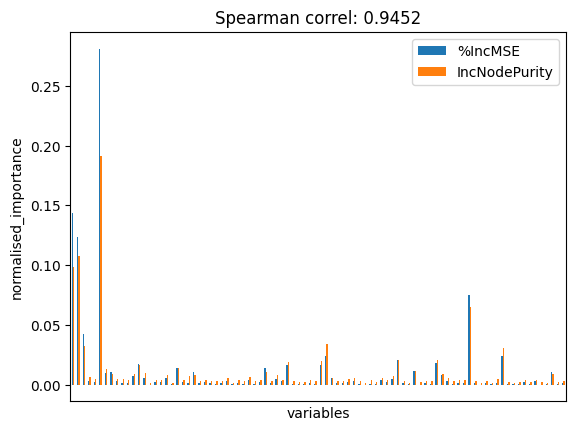

In [18]:
df = pd.DataFrame.from_dict({
    '%IncMSE': mse_importances,
    'IncNodePurity': impurity_importances
})

df.plot.bar()
plt.xlabel('variables')
plt.ylabel('normalised_importance')
plt.title(f'Spearman correl: {correl}')
plt.xticks([])
plt.show()

Since the two variable importance measures are on different scales they have both been normalised to [0,1]. The Spearman correlation between the two sets of variable importances is high as the two sets of rankings are very similar in this case.

Random forest variable importance measures are known to be biased in many scenarios (see Strobl et al, 2007) and so these scores should be interpreted with care.

# Question 2

Let's continue with the same dataset, but this time using a simple neural network. Here, I will do this using Keras but other packages for training a simple neural network could be used.

To install Tensorflow / Keras, refer to:
https://www.tensorflow.org/install/pip

Please read the Keras documentation to understand how to define models: https://keras.io/api/models/model/#with-the-sequential-class

## a) Split the dataset into training and test sets.

In [1]:
import tensorflow as tf

We split the dataset into training and testing set with the training set containing only 40% of the data as for the random forest training. 

It is good practice to normalize your data before training a neural network. There are several different methods to scale the data (z-normalization, min-max scale, etc…) prior to training the network. Choose one type of normalisation and apply it to the training set.

Here I chose to use the z-normalisation so that each variable has mean zero and variance 1.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

n_features = X.shape[1]
x_scaler = StandardScaler()
y_scaler = StandardScaler()

TEST_SIZE = 0.6
train_X, test_X, train_y, test_y = train_test_split(X, y[:, np.newaxis], test_size=TEST_SIZE, random_state=SEED)

train_X = x_scaler.fit_transform(train_X)
train_y = y_scaler.fit_transform(train_y)

## b) Training the network

Train a fully connected network with
* two hidden layers with size 5
* a ReLU activation function for the hidden layers

Keras code consists of three main steps:
1. Constructing a model from layers. This is where you define the architecture.
2. Compiling a model (where you define the loss function and optimiser).
3. Fitting the model (where you define the number of epochs, batch size and pass training data)

The code block below implements the first step:

In [7]:
# A multi-layer perectron (a linear stack of layers) is defined in the Sequential class in keras.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(5, input_dim=90, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 455       
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The code below specifies the optimizer and the loss function and compiles the model:

In [8]:
# you need to specify the optimizer and the loss function
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

Now we can fit the model.

In this example we hold out some validation data (20% of the training set) that is only used to evaluate the loss at the end of each epoch. If the validation loss starts to increase (in which case we are starting to overfit) the training will terminate early - this is known as Early Stopping.

In [9]:
N_EPOCHS = 50
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

train_X2, val_X, train_y2, val_y = train_test_split(train_X, train_y, test_size=VALIDATION_SPLIT, random_state=SEED)

history = model.fit(train_X2, train_y2, epochs=N_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_X, val_y))


Epoch 1/50

126/126 [==============================] - 1s 2ms/step - loss: 0.9122 - val_loss: 0.6793
Epoch 2/50
126/126 [==============================] - 0s 1ms/step - loss: 0.7030 - val_loss: 0.6051
Epoch 3/50
126/126 [==============================] - 0s 1ms/step - loss: 0.6402 - val_loss: 0.5714
Epoch 4/50
126/126 [==============================] - 0s 1ms/step - loss: 0.6032 - val_loss: 0.5505
Epoch 5/50
126/126 [==============================] - 0s 1ms/step - loss: 0.5780 - val_loss: 0.5355
Epoch 6/50
126/126 [==============================] - 0s 1ms/step - loss: 0.5599 - val_loss: 0.5244
Epoch 7/50
126/126 [==============================] - 0s 1ms/step - loss: 0.5450 - val_loss: 0.5171
Epoch 8/50
126/126 [==============================] - 0s 1ms/step - loss: 0.5316 - val_loss: 0.5130
Epoch 9/50
126/126 [==============================] - 0s 1ms/step - loss: 0.5221 - val_loss: 0.5052
Epoch 10/50
126/126 [==============================] - 0s 1ms/step - loss: 0.5128 - val_loss: 0.506

The `fit` function in Keras trains the model for a fixed number of epochs (iterations on a dataset) and returns a `history` object that holds a record of the loss values and metric values during training. 


Ensure your network is training correctly by plotting the loss for each epoch (a learning curve). It should have a decreasing trend, although there may be some small increases due to stochasticity. If your network is not training properly you can change
* the learning rate
* the batch size

If your network is not training at all (e.g. if you have NaNs in the loss function or the loss is diverging) you should decrease the learning rate. Also make sure that there are no NA values in any of your data (this can easily happen when you are rescaling variables).

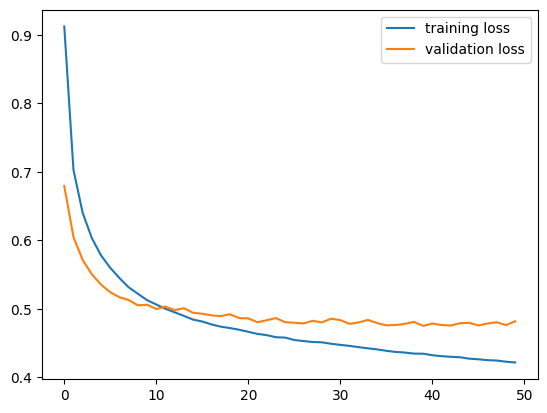

In [10]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

## c) Making predictions


To make predictions, we first need to scale the test dataset. As discussed previously, you could decide to rescale it using the same mean and variance than for the training data. Here we chose to rescale the test set independently from the training data.

Be careful when calculating the MSE when you rescaled labels - if you were to compare these MSE values to the random forest model in the previous section they would be smaller, but that does not necessarily indicate the neural network is a better model as its labels are on a smaller scale.

235/235 [==============================] - 0s 612us/step
Validation MSE: 0.417
Test MSE: 0.53


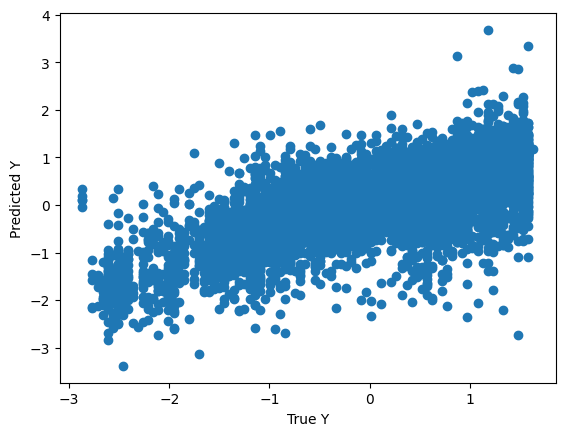

In [14]:
test_X_scaled = x_scaler.transform(test_X)
test_y_scaled = y_scaler.transform(test_y)

# We predict the output for the validation and the test set
pred_train_y = model.predict(train_X2)
train_mse = mean_squared_error(train_y2, pred_train_y)

pred_test_y = model.predict(test_X_scaled)
test_mse = mean_squared_error(test_y_scaled, pred_test_y)

print(f'Validation MSE: {round(train_mse, 3)}')
print(f'Test MSE: {round(test_mse, 3)}')

plt.scatter(test_y_scaled, pred_test_y)
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.show()

## d) Architecture search

Neural networks have many hyperparameters relating to the architecture and training procedure. These include
* the number of hidden layers and their size
* the choice of the activation function
* the learning rate schedule
* the optimisation algorithm
* the batch size

Compare some different networks by varying some of these hyperparameters. These would be selected using cross-validation in practice, but here you can compare them using their test MSEs.


Here we consider 3 different architectures:

In [15]:
model_16 = tf.keras.Sequential()
model_16.add(tf.keras.layers.Dense(16, input_dim=90, activation='relu'))
model_16.add(tf.keras.layers.Dense(1, activation='linear'))

model_16_16 = tf.keras.Sequential()
model_16_16.add(tf.keras.layers.Dense(16, input_dim=90, activation='relu'))
model_16_16.add(tf.keras.layers.Dense(16, activation='relu'))
model_16_16.add(tf.keras.layers.Dense(1, activation='linear'))

model_32 = tf.keras.Sequential()
model_32.add(tf.keras.layers.Dense(32, input_dim=90, activation='relu'))
model_32.add(tf.keras.layers.Dense(1, activation='linear'))

model_list = [model_16, model_16_16, model_32]

fit_histories = []

for model in model_list:
    # optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(train_X2, train_y2, epochs=N_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_X, val_y), verbose=False)
    fit_histories.append(history)

Now make the predictions and plot the results (with MSEs in the legend).


235/235 [==============================] - 0s 603us/step


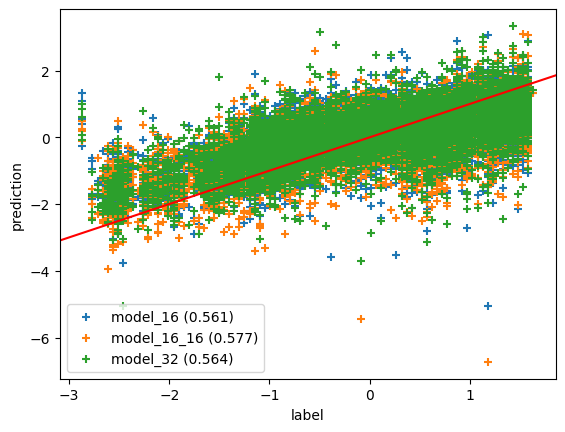

In [16]:
# make predictions on the test set
test_predictions = [model.predict(test_X_scaled) for model in model_list]

# calculate test MSE
mse_list = [mean_squared_error(test_y_scaled, pred) for pred in test_predictions]

for lst, mse, model_name in zip(test_predictions, mse_list, ['model_16', 'model_16_16', 'model_32']):
    plt.scatter(test_y_scaled, lst, label=f'{model_name} ({round(mse, 3)})', marker='+')
plt.legend()
plt.axline((0, 0), slope=1, color="red")
plt.xlabel('label')
plt.ylabel('prediction')
plt.show()


All three models capture some predictive signal and obtain a very similar MSE on the test set.